In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install nltk
!pip install seqeval

In [3]:
import nltk
import seqeval
from seqeval.metrics import classification_report

## Named Entity Recognition (NER)

[NER](https://en.wikipedia.org/wiki/Named-entity_recognition) is a Natural Language Processing (NLP) task that consists in 
  identifying and classifying names of entities (people, location, companies, among others) in a given sentence.
For instance, given the following sentence:

```
Jim bought 300 shares of Acme Corp. in 2006.
```

a NER system should identify and classify the three named entities as in the following:

<font color='blue'>[Jim]<sub>Person</sub></font> bought 
300 shares of 
<font color='red'>[Acme Corp.]<sub>Organization</sub></font> in 
<font color='green'>[2006]<sub>Time</sub></font>.




### IOB Tagging Format
In order to cast NER as a sequence tagging problem, we usually make use of the [IOB Tagging Scheme](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)).
In this scheme, one *IOB tag* is attributed to each token (a token is a word or a punctuation mark) in the input sentence.

Jim | bought | 300 | shares | of | Acme | Corp. | in | 2006 | .
---|---|---|---|---|---|---|---|---|---
`I-PER` | `O` | `O` | `O` | `O` | `I-ORG` | `I-ORG` | `O` | `I-TIME` | `O`

As you can see, each tag identifies the type of the corresponding entity.
The tags `I-<type>` indicates that a token is *inside* an entity of type `<type>`.
Additionally, there is the *out* tag `O` indicating that the token is not part of any entity.
Usually, consecutive tokens classified with the same type are considered part of the same entity.
When there are two consecutive tokens that are part of two different entities but of the same type, we need to use a *begin* tag `B-<type>`. There is one `B-<type>` tag for each entity type.
Such tags indicate the first token of an entity
  when the previous token is part of another entity of the same type.
See the [Wikipedia article](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)) for more details.


### CoNLL-2003 Dataset

The CoNLL-2003 dataset is one of the most used datasets for NER.
In the following, we show a snipet of this dataset.

```
-DOCSTART- -X- -X- O

EU NNP I-NP I-ORG
rejects VBZ I-VP O
German JJ I-NP I-MISC
call NN I-NP O
to TO I-VP O
boycott VB I-VP O
British JJ I-NP I-MISC
lamb NN I-NP O
. . O O

Peter NNP I-NP I-PER
Blackburn NNP I-NP I-PER

(...)

-DOCSTART- -X- -X- O

Rare NNP I-NP O
Hendrix NNP I-NP I-PER
song NN I-NP O

(...)

```

Each line contains a token.
An empty line is used to separate sentences.
A line containing `-DOCSTART- -X- -X- O` is used to separate documents (for NER, usually, we disregard these document boundaries).
Each token contains four features separated by space:
```
word pos_tag chunk_tag ner_tag
```
The first feature `word` contains the string of the token (word or punctuation mark).
The second feature `pos_tag` indicates the part-of-speech of the token.
The third feature `chunk_tag` encodes chunking information (phrases).
And, finally, the last feature `ner_tag` comprises the NER annotations using IOB tagging scheme.

### Training and Evaluation Data
The CoNLL-2003 dataset is split into three parts: train, testa and testb.
The `train` split is obviously used to model training and the remaining two splits are used for model selection and testing.
We will use the `testa` split to evaluate our models.

In [ ]:
# # # download train and dev files
# # !wget https://raw.githubusercontent.com/patverga/torch-ner-nlp-from-scratch/master/data/conll2003/eng.train
# # !wget https://raw.githubusercontent.com/patverga/torch-ner-nlp-from-scratch/master/data/conll2003/eng.testa

# # # Alternative:

# !curl -O https://raw.githubusercontent.com/patverga/torch-ner-nlp-from-scratch/master/data/conll2003/eng.train --progress-bar
# !curl -O https://raw.githubusercontent.com/patverga/torch-ner-nlp-from-scratch/master/data/conll2003/eng.testa --progress-bar


## Encoder

Define a simple class to encode symbols (states and observations names/strings) as integers (IDs).
Basically, we use two entangled data structures: a dictionary (symbol -> ID) and a list (Id -> symbol).

Then, we can represent the HMM parameters as arrays and matrices indexed by integers (IDs) instead of strings.
But, at the same time, we can keep the mapping between symbol name (string) and its ID (integer).

In [4]:
class Encoder:
    """Encode a set of N symbols (strings) into integer IDs from {0, 1, ..., N-1}

    The encoder can be frozen at some point and then no new symbol can be added.
    When a frozen encoder gets a request for an unknown symbol, it raises an
    exception.
    """

    def __init__(self, symbols: list = None, frozen: bool = False):
        """Create a new encoder with optional list of symbols.

        Args:
            symbols (list[str]): list of symbols (default is None)
            frozen (bool): whether the encoder includes new symbols passed to method `get_id(s)` (default is False)
        """
        self.symbol_to_id: dict[str, int] = {}
        self.id_to_symbol: list[str] = []
        self.frozen: bool = False

        if symbols is not None:
            for s in symbols:
                self.get_id(s)

        if frozen:
            self.frozen = True

    def get_id(self, s: str) -> int:
        """return the ID (integer) corresponding to symbols `s`.

        If symbols `s` has not been encoded already and `self.frozen == False`,
        then include `s` in the mapping, assign a new ID for it, and return it.
        If symbols `s` has not been encoded already and `self.frozen == True`,
        raise an exception.

        Args:
            s (str): symbol to be encoded

        Returns:
            int: ID of the encoded symbol
        """
        if s not in self.symbol_to_id:
            if self.frozen:
                raise ValueError(f"Symbol {s} not in frozen encoder {self}")

            new_id = len(self.id_to_symbol)
            self.symbol_to_id[s] = new_id
            self.id_to_symbol.append(s)
            return new_id

        return self.symbol_to_id[s]

    def get_symbol(self, id: int) -> str:
        """return the symbols associated with `id`

        Args:
            id (int): ID of the symbol

        Returns:
            str: the symbol associated with the given ID
        """
        return self.id_to_symbol[id]

    def __repr__(self):
        return f"Encoder: {self.symbol_to_id}"

    def __len__(self):
        return len(self.id_to_symbol)

In [5]:
# define the set of observations (x_enc) and the set of states (y_enc)
x_enc = Encoder()
y_enc = Encoder()

### Encode a token
In the following function, we can apply some transformations to the word string in order to make the taggin problem easier.
One issue with HMM for POS tagging is that there are so many different words, 
  and we need to convert each word into an ID (integer).
Specially, there are related words like `car`, `Car` and `cars`, that should almost always get the same tag, 
  but can be encoded as different IDs.

In [6]:
def encode_token(word, tag):
    """Get features of a token and return a pair (x,y)"""
    # we can apply any transformation to the word in order to make the problem easier
    # word = word.lower()  # lower case
    # word = word[:6]  # ignore long-word ending

    # encode word
    x = x_enc.get_id(word)
    # encode tag
    y = y_enc.get_id(tag)

    return x, y

The function below iterates over a CoNLL file (train or evaluation), 
  encodes each word and its NER tag, 
  and returns two lists: `xs` and `ys`.
Each element in `xs` comprises a sentence of the file (np.array of encoded words).
And each element in `ys` comprises the corresponding sequence of tags (np.array of encoded tags).

In [7]:
def load_examples(file):
    xs = []
    ys = []
    with open(file) as f:
        x_sent = []
        y_sent = []
        for line in f:
            if len(line.strip()) == 0:
                # a blank line separates sentences
                if len(x_sent) > 0:
                    # end of a sentence
                    xs.append(np.array(x_sent))
                    ys.append(np.array(y_sent))
                    x_sent = []
                    y_sent = []
            elif line.startswith("-DOCSTART-"):
                # start of a new document (ignore document limits)
                pass
            else:
                # a token contains four fields (separated by space):
                # word, POS tag, noun-phrase tag, and NER tag
                # the function `encode_example(...)` gets the word and NER tag
                # of a token and return an encoded pair (x,y)
                word, _, _, tag = line.split()
                x, y = encode_token(word, tag)
                x_sent.append(x)
                y_sent.append(y)

    return xs, ys

Load train and evaluation (dev) datasets.

In [15]:
x_train, y_train = load_examples("eng.train")
x_dev, y_dev = load_examples("eng.testa")

Freeze the encoders to avoid bugs.

In [16]:
x_enc.frozen = True
y_enc.frozen = True

Number of sentences in each dataset.

In [17]:
print(f"# train exs: {len(x_train)}")
print(f"# dev exs: {len(x_dev)}")

# train exs: 14041
# dev exs: 3250


Number of unique words in the datasets.

In [18]:
print(f"# unique x: {len(x_enc)}")

# unique x: 26883


Number of tags.

In [19]:
print(f"# unique y: {len(y_enc)}")

# unique y: 8


Visualize the tags and their corresponding IDs.

In [20]:
y_enc

Encoder: {'I-ORG': 0, 'O': 1, 'I-MISC': 2, 'I-PER': 3, 'I-LOC': 4, 'B-LOC': 5, 'B-MISC': 6, 'B-ORG': 7}

Distribution of the tags.
We can already see an issue with NER: the output tag `O` is much more frequent than all other tags.

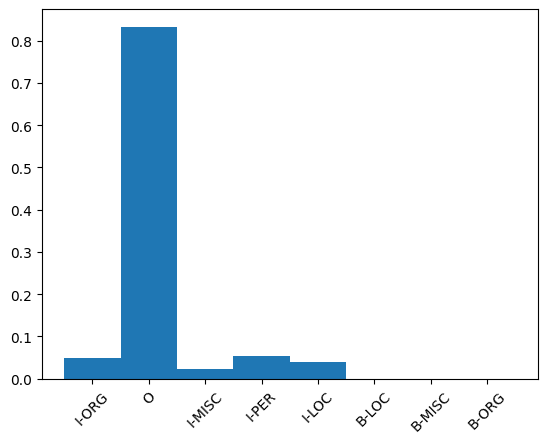

In [21]:
_ = plt.hist(
    [y_enc.get_symbol(y) for y_seq in y_train for y in y_seq],
    bins=range(len(y_enc) + 1),
    align="left",
    density=True,
)
_ = plt.xticks(rotation=45)

So let us have a look at the distribution of tags ignoring the `O` tag.
Now, we have another issue because the `B-<type>` tags are also very rare when compared to the `I-<type>` tags.

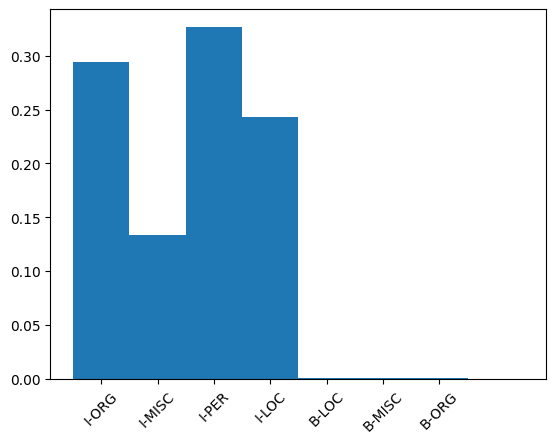

In [22]:
_ = plt.hist(
    [y_enc.get_symbol(y) for y_seq in y_train for y in y_seq if y != y_enc.get_id("O")],
    bins=range(len(y_enc) + 1),
    align="left",
    density=True,
)
_ = plt.xticks(rotation=45)

In [23]:
from collections import Counter

counter = Counter([y_enc.get_symbol(y) for y_seq in y_train for y in y_seq])
total = sum(counter.values())
print({tag: count / total for tag, count in counter.items()})

{'I-ORG': 0.04911575918004528, 'O': 0.832811939829389, 'I-MISC': 0.02237490239218941, 'I-PER': 0.05465055176037835, 'I-LOC': 0.040693248731712345, 'B-LOC': 5.402193290475933e-05, 'B-MISC': 0.0001817101379523723, 'B-ORG': 0.00011786603542856582}


## Evaluation Script
NER models are usually evaluated using the CoNLL-2003 evaluation metric.
This metric considers [precision, recall and f1-score](https://en.wikipedia.org/wiki/Precision_and_recall).
In this implementation, these values are computed with respect to entities instead of individual tokens.
A predicted entity is consired correct only if the exact tokens are correctly identified and classified.

We use the seqeval library to compute the CoNLL metric.
More specifically, we use the `classification_report` function 
  which reports precision, recall, f1-score and support for each entity type plus three averages over the entity types: micro, macro and weigthed.
In the following, you can see an example of this classification report.
The most important value in this table is the micro-averaged f1-score (`0.55` in the example).

```
              precision    recall  f1-score   support

         LOC       0.84      0.78      0.81      1837
        MISC       0.74      0.70      0.72       922
         ORG       0.21      0.76      0.32      1341
         PER       0.69      0.54      0.60      1842

   micro avg       0.45      0.69      0.55      5942
   macro avg       0.62      0.70      0.61      5942
weighted avg       0.63      0.69      0.62      5942
```

In [25]:
def ids_to_tags(y):
    y_tags = []
    for y_k in y:
        y_tags.append([y_enc.get_symbol(tag) for tag in y_k])
    return y_tags


def cr_eval(y, y_pred):
    y = ids_to_tags(y)
    y_pred = ids_to_tags(y_pred)
    return classification_report(y, y_pred)

## Most Frequent Tag for each Token
It is always a good idea to implement a simple baseline method in order to have a reference performance.
In the following, we evaluate a baseline that, for each token, predicts the most frequent tag for this token in the training data.

In [51]:
# count occurrences of each word (row) x tag (column) on training data
freq_x_y = np.zeros((len(x_enc), len(y_enc)))
for x_k, y_k in zip(x_train, y_train):
    for x_t, y_t in zip(x_k, y_k):
        freq_x_y[x_t, y_t] += 1

# most frequent tag for each word
most_freq_x = freq_x_y.argmax(axis=1)

pred_y = []
for x_k in x_dev:
    pred_y.append(np.array([most_freq_x[x_t] for x_t in x_k]))

print(f'Evaluation of "Most Frequent per Token":\n\n{cr_eval(y_dev, pred_y)}')

Evaluation of "Most Frequent per Token":

              precision    recall  f1-score   support

         LOC       0.84      0.78      0.81      1837
        MISC       0.74      0.70      0.72       922
         ORG       0.21      0.76      0.32      1341
         PER       0.69      0.54      0.60      1842

   micro avg       0.45      0.69      0.55      5942
   macro avg       0.62      0.70      0.61      5942
weighted avg       0.63      0.69      0.62      5942



## Maximum Likelihood Estimation (MLE)
Now, let us estimate the parameters $\theta=(\pi,a,b)$ of an HMM 
  by maximizing the likelihood of the model in the training dataset $\mathcal D = \{(X,Y)\}$: 

$$
\max_\theta \prod_{(X,Y) \in \mathcal D} P(X,Y|\theta)
$$

Remember from the lecture that the HMM parameters that maximize the likelihood are given as the following.

- for the start probabilities:
$$
\pi_i = \frac{\sum_{Y \in \mathcal D} [[y_1 = i]]}{M},
$$
where 
  $[[c]]$ is the indicator function (it is equal to $1$ if $c$ is true and $0$ otherwise),
  and $M$ is the number of examples in $D$.

- for the observation probabilities:
$$
b_j(k) = \frac{\sum_{(X,Y) \in \mathcal D} \sum_{t=1}^T [[y_t=j \text{ and } x_t=k]]}{\sum_{Y \in \mathcal D} \sum_{t=1}^T [[y_t=j]]},
$$

- and, finally, for the transition probabilities:
$$
a_{ij} = \frac{\sum_{Y \in \mathcal D} \sum_{t=2}^T [[y_{t-1}=i \text{ and } y_t=j]]}{\sum_{Y \in \mathcal D} \sum_{t=2}^T [[y_{t-1}=i]]}.
$$


In [57]:
def estimate_mle(xs, ys, num_states, num_observations):
    # create counting arrays with ones
    #
    # Theoretically, we should start these counters with zero.
    # However, there is an issue when working with HMMs for sparse data.
    # It is common to have some observation-tag pairs (in this case,
    # token-ner_type) that never occur in training data.
    # And, when this happen, some paths in the trellis will just have
    # zero probability. This is already a bad thing. But now think about
    # what this means in the log-domain.
    #
    # So, by starting all counts with one, we avoid this issue.
    #
    pi_est = np.ones((num_states))
    a_est = np.ones((num_states, num_states))
    b_est = np.ones((num_states, num_observations))

    for x, y in zip(xs, ys):
        # count number of start states
        pi_est[y[0]] += 1
        # consider emission on first state
        b_est[y[0], x[0]] += 1
        # count transitions and emissions
        for t in range(1, len(y)):
            # emission
            b_est[y[t], x[t]] += 1
            # transition
            a_est[y[t - 1], y[t]] += 1

    # normalize counts
    pi_est = pi_est / len(xs)
    a_est = a_est / a_est.sum(axis=1, keepdims=True)
    b_est = b_est / b_est.sum(axis=1, keepdims=True)

    return pi_est, a_est, b_est

In [58]:
pi, a, b = estimate_mle(x_train, y_train, len(y_enc), len(x_enc))

## Viterbi Algorithm

We reuse the vectorized solution from the previous exercise.

### Pseudo-code

Given input sequence $X=(x_1,x_2,\ldots,x_T)$ and HMM parameters $\pi, a, b$, 
  as described above,
  return $Y^* = \arg\max_Y P(Y|X)$

- Initialization
  - for $i=1,\ldots,N$
    - $\log\delta_1(i) = \log\pi_i + \log b_i(x_1)$, 
    - $\psi_1(i) = -1$
- for $t = 2, \ldots, T$
  - for $j = 1, \ldots, N$
    - $\log\delta_t(j) = \max_i (\log\delta_{t-1}(i) + \log a_{ij}) + \log b_j(x_t)$
    - $\psi_t(j) = \arg\max_i (\log\delta_{t-1}(i) + \log a_{ij})$
- Recover best sequence $Y^* = (y^*_1, \ldots, y^*_T) = \arg\max_y P(Y|X)$
  - $y^*_T = \arg\max_i\delta_T(i)$
  - for $t = T-1, \ldots, 1$
   - $y^*_t = \psi_{t+1}(y^*_{t+1})$

### Code

In [59]:
def viterbi_v(x, pi, a, b):
    num_states = pi.size
    seq_len = len(x)

    # let's work on the log domain (base 2)
    log_pi = np.log2(pi)
    log_a = np.log2(a)
    log_b = np.log2(b)

    log_delta = np.zeros((seq_len, num_states))
    psi = np.full((seq_len, num_states), -1, dtype=np.int32)

    # initilization
    log_delta[0] = log_pi + log_b[:, x[0]]

    for t in range(1, seq_len):
        # Sum log_delta[t-1] (array of log_delta in the previous step) with
        # log_a matrix. Since delta[t-1] is an array, we want to broadcast its
        # second dimension through the first dimension of log_a (which
        # represents the i state on a transition i->j). So that, in the end,
        # we have log_delta_a[i,j] = log_delta[t-1,i] + log_a[i,j]
        log_delta_a = log_delta[t - 1].reshape(-1, 1) + log_a

        # log_delta is the max value plus the emission probability on
        # time-step t. The max is taken along the first dimension, i.e., the max
        # along the previous state `i` for each state `j`.
        log_delta[t] = log_delta_a.max(axis=0) + log_b[:, x[t]]

        # psi is the argmax
        psi[t] = log_delta_a.argmax(axis=0)

    # now we recover the most likely sequence of states backwards, from the last
    # time step (in Python, -1 represents the last index of a list/array) up to
    # the first one.
    y = []
    # here we use the argmax() method of a numpy array to find the best
    # state on the last time step
    y.append(log_delta[-1].argmax())
    for t in range(seq_len - 1, 0, -1):
        y.append(psi[t, y[-1]])

    # the list y is backwards, so reverse it and return
    y.reverse()
    return y, log_delta, psi

## Evaluate Trained HMM
Now that we have estimated the maximum likelihood HMM from the train dataset, we can evaluate its performance in the evaluation dataset.

In [60]:
ys_pred = []
for x in x_dev:
    y, _, _ = viterbi_v(x, pi, a, b)
    ys_pred.append(np.array(y))

print(f'Evaluation of "HMM-MLE":\n\n{cr_eval(y_dev, ys_pred)}')

Evaluation of "HMM-MLE":

              precision    recall  f1-score   support

         LOC       0.90      0.74      0.81      1837
        MISC       0.80      0.56      0.66       922
         ORG       0.57      0.56      0.56      1341
         PER       0.83      0.53      0.65      1842

   micro avg       0.78      0.61      0.68      5942
   macro avg       0.78      0.60      0.67      5942
weighted avg       0.79      0.61      0.68      5942



In [61]:
ys_pred

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([4, 1]),
 array([4, 4, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 4, 1, 3, 3, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1]),
 array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 4, 1]),
 array([3, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 4, 1, 0, 1, 3, 3, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1

## Comparision with optimizing for *individually* most likely hidden states

We are referring to the [forward-backward algorithm](https://en.wikipedia.org/wiki/Forward%E2%80%93backward_algorithm) provided as a primer for the Viterbi algorithm in Section III.B of Rabbiner (1989).

### Approach

Given input sequence $X=(x_1,x_2,\ldots,x_T)$ and HMM parameters $\lambda = \{\pi, a, b\}$, 
  as described above,
  return $y_t^* = \arg\max_{y_t} P(y_t|X)$ for $t \in \{ 1, \ldots, T\}$.

According to Rabiner (1989), we want to solve for $y_t = \arg\max_{i \in \{ 1, \ldots, N\}} \gamma_t(i)$ for $t \in \{ 1, \ldots, T\}$, where $\gamma_t(i) = P(y_t = i | X, \lambda) = \frac{\alpha_t(i)\beta_t(i)}{P(X|\lambda)}$.

We know how to calculate $\alpha_t(i)$ and $\beta_t(i)$ from the text:

Pseudo code for calculation of $\alpha_t(i)$:

- Initialization
  - for $i=1,\ldots,N$
    - $\alpha_1(i) = \pi_i b_i(x_1)$, 
- for $t = 1, \ldots, T-1$
  - for $j = 1, \ldots, N$
    - $\alpha_{t+1}(j) = \left[ \sum_{i=1}^N \alpha_t(i)a_{ij} \right] b_j(x_{t+1})$

Pseudo code for calculation of $\beta_t(i)$:

- Initialization
  - for $i=1,\ldots,N$
    - $\beta_T(i) = 1$, 
- for $t = T-1, \ldots, 1$
  - for $i = 1, \ldots, N$
    - $\beta_{t}(i) = \sum_{j=1}^N a_{ij} b_j(x_{t+1}) \beta_{t+1}(j)$

We further know, that:

$P(X|\lambda) = \sum_{i=1}^N \alpha_T(i) = \sum_{i=1}^N \alpha_t(i) \beta_t(i)$

While we won't need that for finding the $\arg\max_{i \in \{ 1, \ldots, N\}} \gamma_t(i)$, it might proof helpfull in asserting that we are implementing things correctly.

### Code

Unvectorized first, with operations in log-space.

In [62]:
def forward_backward(x, pi, a, b, debug=True):
    from scipy.special import logsumexp

    num_states = pi.size
    seq_len = len(x)

    # let's work on the log (base e in this case, due to logsumexp trick implementation)
    log_pi = np.log(pi)
    log_a = np.log(a)
    log_b = np.log(b)

    log_alpha = np.zeros((seq_len, num_states))
    log_beta = np.zeros((seq_len, num_states))

    # calculate alpha
    for i in range(num_states):
        log_alpha[0, i] = log_pi[i] + log_b[i, x[0]]
    for t in range(seq_len-1):
        for j in range(num_states):
            log_alpha[t+1, j] = logsumexp(log_alpha[t, :] + log_a[:, j] + log_b[j, x[t+1]])

    # calculate beta
    log_beta[-1] = 0  # redundant, due to initialization above 0 = log(1)
    for t in range(seq_len-2,-1,-1):
        for i in range(num_states):
            log_beta[t, i] = logsumexp(log_a[i, :] + log_b[:, x[t+1]] + log_beta[t+1, :])
    
    # calculate log_gamma (unnormalized)
    log_gamma_unnormalized = log_alpha + log_beta

    if debug == True:
        # calculate log_p_x_lambda (and check if values are as expected)
        log_p_x_lambda = np.zeros(seq_len)
        for t in range(seq_len):
            log_p_x_lambda[t] = logsumexp(log_alpha[t] + log_beta[t])
        
        assert np.allclose(log_p_x_lambda, log_p_x_lambda[0])
        try:
            assert 0 <= np.exp(log_p_x_lambda[0]) <= 1
        except:
            raise ValueError(f"{log_p_x_lambda=}")

        gamma = np.exp(log_gamma_unnormalized - log_p_x_lambda.reshape(-1, 1))
        try:
            assert (0 <= gamma).all() and (gamma <= 1).all()
        except:
            raise ValueError(f"gamma:\n{gamma}")
    else:
        log_p_x_lambda = None
    
    # get argmax over gammas
    y = np.argmax(np.exp(log_gamma_unnormalized), axis=1)
        
    return y, log_alpha, log_beta, log_p_x_lambda

And now for the vectorized version:

In [63]:
def forward_backward_v(x, pi, a, b, debug=True):
    from scipy.special import logsumexp

    num_states = pi.size
    seq_len = len(x)

    # let's work with logs (base e in this case, due to logsumexp trick implementation)
    log_pi = np.log(pi)
    log_a = np.log(a)
    log_b = np.log(b)

    log_alpha = np.zeros((seq_len, num_states))
    log_beta = np.zeros((seq_len, num_states))

    # calculate alpha
    log_alpha[0] = log_pi + log_b[:, x[0]]
    for t in range(seq_len-1):
        log_alpha[t+1] = logsumexp(log_alpha[t, :].reshape(-1, 1) + log_a[:, :] + log_b[:, x[t+1]].reshape(1, -1), axis=0)

    # calculate beta
    log_beta[-1] = 0  # redundant, due to initialization above 0 = log(1)
    for t in range(seq_len-2,-1,-1):
        log_beta[t] = logsumexp(log_a[:, :] + log_b[:, x[t+1]].reshape(1, -1) + log_beta[t+1, :], axis=1)
    
    # calculate log_gamma (unnormalized)
    log_gamma_unnormalized = log_alpha + log_beta

    if debug == True:
        # calculate log_p_x_lambda (and check if values are as expected)
        log_p_x_lambda = np.zeros(seq_len)
        for t in range(seq_len):
            log_p_x_lambda[t] = logsumexp(log_alpha[t] + log_beta[t])
        
        assert np.allclose(log_p_x_lambda, log_p_x_lambda[0])
        try:
            assert 0 <= np.exp(log_p_x_lambda[0]) <= 1
        except:
            raise ValueError(f"{log_p_x_lambda=}")

        gamma = np.exp(log_gamma_unnormalized - log_p_x_lambda.reshape(-1, 1))
        try:
            assert (0 <= gamma).all() and (gamma <= 1).all()
        except:
            raise ValueError(f"gamma:\n{gamma}")
    else:
        log_p_x_lambda = None
    
    # get argmax over gammas
    y = np.argmax(np.exp(log_gamma_unnormalized), axis=1)
        
    return y, log_alpha, log_beta, log_p_x_lambda

In [64]:
# testing vectorized version

for x in  x_dev[:10]:
    y, log_alpha, log_beta, log_p_x_lambda = forward_backward(x, pi, a, b)
    y_v, log_alpha_v, log_beta_v, log_p_x_lambda_v = forward_backward_v(x, pi, a, b)

    assert np.allclose(log_alpha, log_alpha_v)
    assert np.allclose(log_beta, log_beta_v)
    assert np.allclose(log_p_x_lambda, log_p_x_lambda_v)

## Evaluate predictions of forward-backward algorithm
To compare with the Viterbi algorithm, we evaluate the performance of our implementation on the evaluation dataset.

In [65]:
ys_pred = []
for x in x_dev:
    y, _, _, _ = forward_backward_v(x, pi, a, b, debug=True)
    ys_pred.append(np.array(y))

print(f'Evaluation of "HMM-MLE":\n\n{cr_eval(y_dev, ys_pred)}')

Evaluation of "HMM-MLE":

              precision    recall  f1-score   support

         LOC       0.90      0.74      0.81      1837
        MISC       0.80      0.58      0.67       922
         ORG       0.56      0.57      0.57      1341
         PER       0.79      0.49      0.61      1842

   micro avg       0.76      0.60      0.67      5942
   macro avg       0.76      0.60      0.66      5942
weighted avg       0.77      0.60      0.67      5942



In [101]:
ys_pred

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([4, 1]),
 array([4, 2, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]),
 array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 4, 1, 3, 3, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1]),
 array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 4, 1]),
 array([3, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 4, 1, 0, 1, 3, 3, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1